In [98]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats

In [179]:
class createSet(object): # Make this subclass pd dataframe? #https://stackoverflow.com/questions/22155951/how-to-subclass-pandas-dataframe
    '''This creates pandas dataframe of a specified size with generated features of
    various distributions and a dependent variable of a specified skewness. 
    
    This class also has a few methods for creating additional, completely random features with 
    a function call. These can be of specified distribution but are truly random and are likely
    to have correlations close to zero with the target variable.
    
    The outlier method removes rows at random and replaces them with outliers: use "all" to get
    extreme values in every column, or specify 'columns=[]' to get outliers in only some features.
    '''
    
    def __init__(self,size=10000, targetskew=0, corr=0.7, multicol=0.0):
        self.size = size
        
        #create a baseline dataset with the correlations we want. This creates a series 
        #with mean zero and std=1 and the correlations specified by the covariance matrix (cov=)
        mvnorm = stats.multivariate_normal(mean=[0, 0, 0], cov=[[1., corr, corr], 
                                                                [corr, 1., multicol],
                                                                [corr, multicol, 1.]])
        raw = mvnorm.rvs(self.size)
        #create the target variable with the specified targetskew
        targetMean = 6000
        targetStd = 2000
        
        if targetskew:
            self.standardNormalTarget =  raw[:,0]
            intendedSortOrder = stats.rankdata(self.standardNormalTarget, method='ordinal')
            sortedSkew = np.sort(stats.skewnorm.rvs(a=targetskew, loc=targetMean,scale=targetStd, size=self.size))
            self.hoursSpent = [sortedSkew[i-1] for i in intendedSortOrder]
            df = pd.DataFrame(self.hoursSpent, columns=['hoursSpent'])
        else:
            self.standardNormalTarget =  raw[:,0]
            intendedSortOrder = stats.rankdata(self.standardNormalTarget, method='ordinal')
            self.hoursSpent = self.standardNormalTarget*targetStd + targetMean
            df = pd.DataFrame(self.hoursSpent, columns=['hoursSpent'])
        
        #Some of the features will be calculated using the target variable to artificially create some
        # correlation. However, I don't want them to automatically inherit the skewness of the target
        # variable, so instead of basing the independing variables directly on the target, I will 
        # create a normal distribution on the same scale that is sorted to match the order of the 
        # target variable. That enables creating correlated features without inheriting skew.
        
        
        #This adds a normally distributed feature with the correlations specified by the 2nd column of (cov=)
        #The std (3K) and mean (12K) are arbitrarily chosen to make the data intuitive (few/no negatives)
        df['screenActions'] = raw[:,1]*3000 + 12000
        df['screenActions'] = df['screenActions'].astype('int') 

        #This adds a uniformly distributed feature with the correlations specified by the 3rd column of (cov=)
        norm = stats.norm()
        uniformed = norm.cdf(raw[:,2])
        df['picsPerMonth'] = uniformed*300 + (np.max(uniformed) - np.min(uniformed))
        df['picsPerMonth'] = df['picsPerMonth'].astype('int') 
#         def unif(self, p):
#             return np.random.choice(a=[np.random.uniform(high=150),np.random.uniform(low=150.1,high=300)], p=p)
#         df['picsPerMonth'] = [unif(self,[(1-float(i/self.size)), float(i/self.size)]) for i in intendedSortOrder]

        #This adds a poisson distribution that's typically around .17 correlation
        df['timesDropped'] = [np.random.poisson(lam=1.5) if x > targetMean else 
                              np.random.poisson(lam=1.0) for x in self.standardNormalTarget]

        #This adds a dual-peak gamma distribution for owner age, typically around -.12 correlation
        def gam(self, p):
            return np.random.choice(a=[np.random.gamma(shape=25.0,scale=1),
                          np.random.gamma(shape=25.0,scale=1.8)], p=p)
        df['ownerAge'] = [gam(self,[.6,.4]) if x >targetMean else 
                          gam(self,[.4,.6]) for x in self.standardNormalTarget]

        #This adds a bernoulli distribution for whether the phone is rooted, typically around .06 correlation
        df['rooted'] = [np.random.binomial(1, .05) if x > targetMean*1.5 else
                        np.random.binomial(1, .005) for x in self.standardNormalTarget]

        #This adds a categorical variable that slightly corresponds to the target
        def osChoice(self, p):
            return np.random.choice(a=['iOS', 'Android', 'other'], p=p)
        df['os'] = [osChoice(self,[.415,.575,.01]) if x > targetMean else 
                               osChoice(self,[.335,.635,.03]) for x in self.standardNormalTarget]
               
        self.df = df
        
    def addContFeatures(self, feats={'normal':1}):
        for shape, cnt in feats.items():
            if shape == 'normal':
                for j in range(cnt):
                    Y = np.random.normal(loc=targetMean,scale=targetStd, size=self.size)
                    self.df['normalFeat_'+str(self.cons)] = Y
                    self.cons=self.cons+1
            elif shape == 'uniform':
                for j in range(cnt):
                    Y = np.random.uniform(size=self.size)*(targetMean*2)
                    self.df['uniformFeat_'+str(self.cons)] = Y
                    self.cons=self.cons+1
            elif shape == 'poisson':
                for j in range(cnt):
                    Y = np.random.poisson(lam=1.0,size=self.size)
                    self.df['poissonFeat_'+str(self.cons)] = Y
                    self.cons=self.cons+1
            elif shape == 'gamma':
                for j in range(cnt):
                    Y = np.random.gamma(shape=2.0,scale=2,size=self.size)
                    self.df['gammaFeat_'+str(self.cons)] = Y
                    self.cons=self.cons+1
                    
                
            else:
                print('NOTE: received invalid distribution type. Try \"normal\", \"uniform\", or ')
    
    def addCatFeatures(self, feats={'sex':['male', 'female']}):
        for name, values in feats.items():
            odds = np.random.randint(low=0, high=len(values),size=self.size)
            self.df[name] = [values[x] for x in odds]
            del odds
            
    def addOutliers(self, cnt=5):
        #code this
        self.df = df
        
        
        
            
        

In [180]:
#this cell doesn't need to run; It checks 100 iterations of the class createSet() to see how the features
# tend to correlate with the target variable (given that they are generated dynamically)
#It's only useful when I update how a feature is calculated

import time
start = time.time()
screencorrs = []
picscorrs = []
dropscorrs = []
agecorrs = []
rootcorrs = []
for i in range(100):
    u = createSet(size=1000)
    cor = u.df.corr()
    screencorrs.append(cor.loc['hoursSpent','screenActions'])
    picscorrs.append(cor.loc['hoursSpent','picsPerMonth'])
    dropscorrs.append(cor.loc['hoursSpent','timesDropped'])
    agecorrs.append(cor.loc['hoursSpent','ownerAge'])
    rootcorrs.append(cor.loc['hoursSpent','rooted'])
print('Correlations: \n')
print('screenActions (Normal Variable)\n',np.mean(screencorrs),'\n', np.std(screencorrs), '\n')
print('picsPerMonth (Uniform Variable) \n',np.mean(picscorrs),'\n', np.std(picscorrs), '\n')
print('timesDropped (Poisson Variable) \n',np.mean(dropscorrs),'\n', np.std(dropscorrs), '\n')
print('ownerAge (Gamma Variable) \n',np.mean(agecorrs),'\n', np.std(agecorrs), '\n')
print('rooted (Bernoulli Variable)\n',np.mean(rootcorrs),'\n', np.std(rootcorrs), '\n')
print('done in ', time.time() - start, 'seconds')
u.df.corr()

Correlations: 

screenActions (Normal Variable)
 0.6986625642763081 
 0.01483951613402438 

picsPerMonth (Uniform Variable) 
 0.681988936028417 
 0.01748277340872702 

timesDropped (Poisson Variable) 
 0.003573696157221341 
 0.031231246764944556 

ownerAge (Gamma Variable) 
 0.0072958960831007846 
 0.02739084941109087 

rooted (Bernoulli Variable)
 0.003519610273431325 
 0.032383988549296895 

done in  7.1962995529174805 seconds


,hoursSpent,screenActions,picsPerMonth,timesDropped,ownerAge,rooted
hoursSpent,1.000000,0.706994,0.692043,0.008684,0.018001,-0.014411
screenActions,0.706994,1.000000,0.022179,-0.007133,0.037845,-0.020076
picsPerMonth,0.692043,0.022179,1.000000,0.016199,-0.019389,-0.002159
timesDropped,0.008684,-0.007133,0.016199,1.000000,-0.028187,-0.009471
ownerAge,0.018001,0.037845,-0.019389,-0.028187,1.000000,0.008736
rooted,-0.014411,-0.020076,-0.002159,-0.009471,0.008736,1.000000


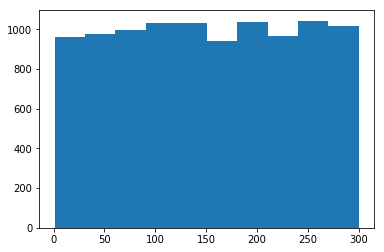

hoursSpent      -1366.81
screenActions      -1374
picsPerMonth           1
timesDropped           0
ownerAge         10.9451
rooted                 0
os               Android
dtype: object

hoursSpent       13378.6
screenActions      23636
picsPerMonth         300
timesDropped           6
ownerAge         84.5956
rooted                 1
os                 other
dtype: object

In [182]:
u = createSet(size=10000)
plt.hist(u.df.picsPerMonth)
plt.show()
display(u.df.min())
display(u.df.max())

---------------------------------------------------------------------------

---------------------------------------------------------------------------

---------------------------------------------------------------------------

---------------------------------------------------------------------------

_________________

In [183]:
#Let's create one for vizualization

viz = createSet(targetskew=0)
print(viz.df.shape)
display(viz.df.head())
viz.df.corr()

(10000, 7)


,hoursSpent,screenActions,picsPerMonth,timesDropped,ownerAge,rooted,os
0,3398.127788,10194,43,0,50.201384,0,Android
1,2971.235808,12280,4,1,38.485501,0,Android
2,330.657213,8510,1,0,35.537584,0,iOS
3,6014.944950,11027,207,2,54.811336,0,Android
4,6224.634810,12197,169,0,22.622139,0,iOS


,hoursSpent,screenActions,picsPerMonth,timesDropped,ownerAge,rooted
hoursSpent,1.000000,0.688184,0.690393,-0.008103,0.000249,0.000863
screenActions,0.688184,1.000000,-0.006965,0.009648,0.013508,-0.013961
picsPerMonth,0.690393,-0.006965,1.000000,-0.012269,-0.017145,0.011847
timesDropped,-0.008103,0.009648,-0.012269,1.000000,0.007002,-0.006799
ownerAge,0.000249,0.013508,-0.017145,0.007002,1.000000,-0.009867
rooted,0.000863,-0.013961,0.011847,-0.006799,-0.009867,1.000000


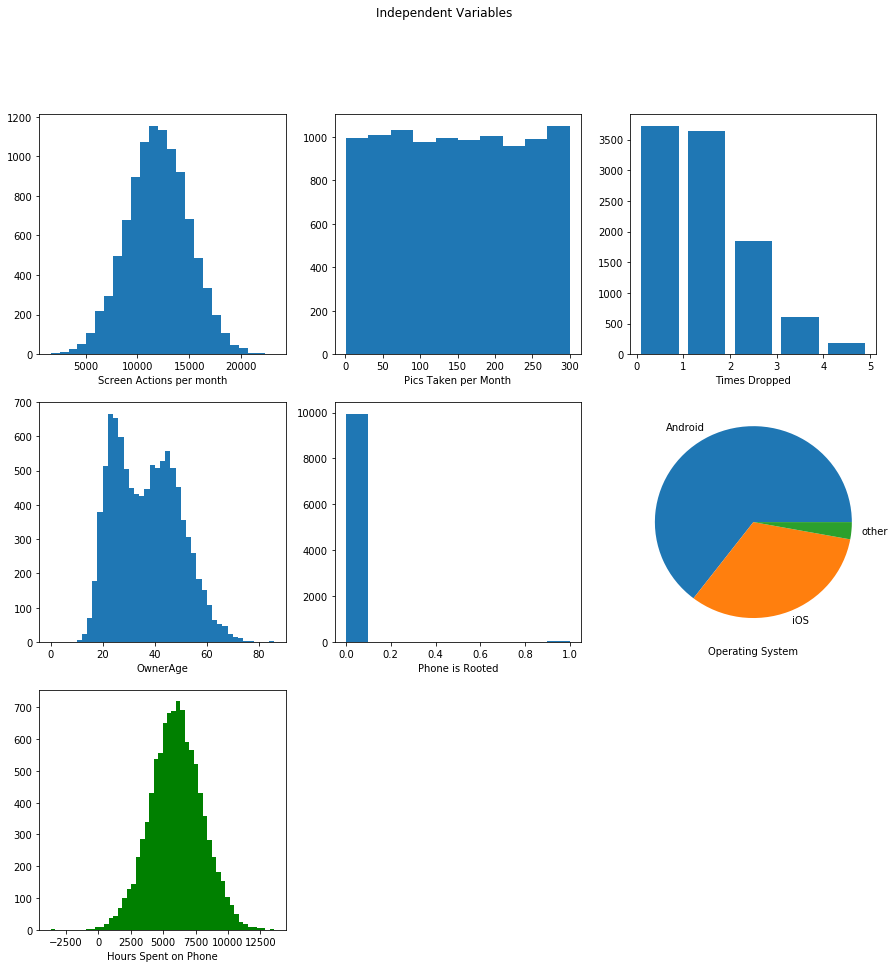

In [184]:
#Core feature Histograms

plt.figure(figsize=(15,15))
plt.suptitle('Independent Variables')
plt.subplot(331)
plt.hist(viz.df.screenActions, bins=25)
plt.xlabel('Screen Actions per month')
plt.subplot(332)
plt.hist(viz.df.picsPerMonth)#, bins=np.arange(0,max(viz.df.picsPerMonth),25))
plt.xlabel('Pics Taken per Month')
plt.subplot(333)
plt.hist(viz.df.timesDropped, bins=np.arange(0,max(viz.df.timesDropped),1), rwidth = .8)
plt.xlabel('Times Dropped')
plt.subplot(334)
plt.hist(viz.df.ownerAge, bins=np.arange(0,max(viz.df.ownerAge),2))
plt.xlabel('OwnerAge')
plt.subplot(335)
plt.hist(viz.df.rooted)#, bins=np.arange(0,40,3))
plt.xlabel('Phone is Rooted')
plt.subplot(336)
viz.df['os'].value_counts().plot(kind='pie')
plt.xlabel('Operating System')
plt.ylabel('')
plt.subplot(337)
plt.hist(viz.df.hoursSpent, color='g', bins=50)#, bins=np.arange(0,40,3))
plt.xlabel('Hours Spent on Phone')

plt.show()







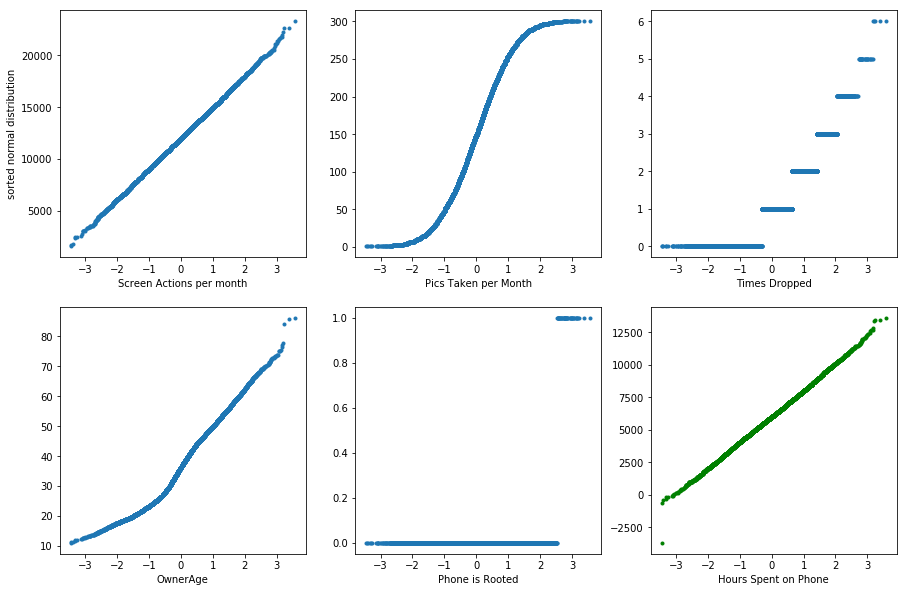

In [185]:
#Quartile Plot compared to random normal

norm = np.random.normal(0, 1, viz.size)
norm.sort()
norm1 = viz.df['screenActions'].sort_values()
uni2 =  viz.df['picsPerMonth'].sort_values()
pois3 =  viz.df['timesDropped'].sort_values()
gamma4 = viz.df['ownerAge'].sort_values()
bern = viz.df['rooted'].sort_values()
target = viz.df['hoursSpent'].sort_values()

plt.figure(figsize=(15,10))
plt.subplot(231)
plt.plot(norm, norm1, ".")
plt.ylabel('sorted normal distribution')
plt.xlabel('Screen Actions per month')
plt.subplot(232)
plt.plot(norm, uni2, ".")
plt.xlabel('Pics Taken per Month')
plt.subplot(233)
plt.plot(norm, pois3, ".")
plt.xlabel('Times Dropped')
plt.subplot(234)
plt.plot(norm, gamma4, ".")
plt.xlabel('OwnerAge')
plt.subplot(235)
plt.plot(norm, bern, ".")
plt.xlabel('Phone is Rooted')
plt.subplot(236)
plt.plot(norm, target, "g.")
plt.xlabel('Hours Spent on Phone')
plt.show()

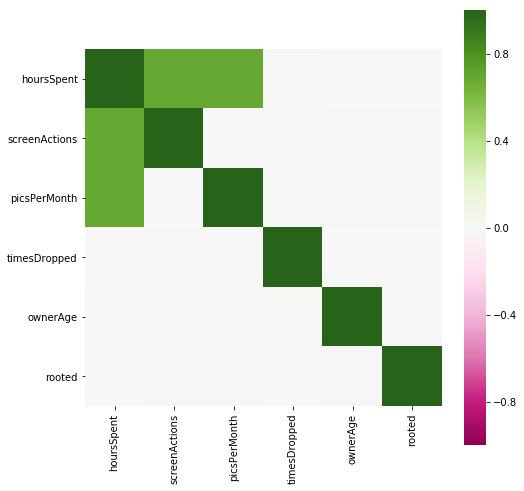

In [186]:
plt.figure(figsize=[8,8])
sns.heatmap(viz.df.corr(), vmin = -1,square=True, cmap="PiYG")
plt.show()

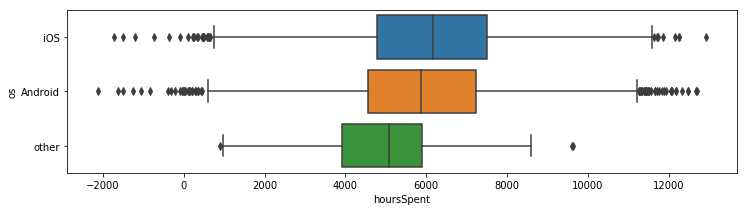

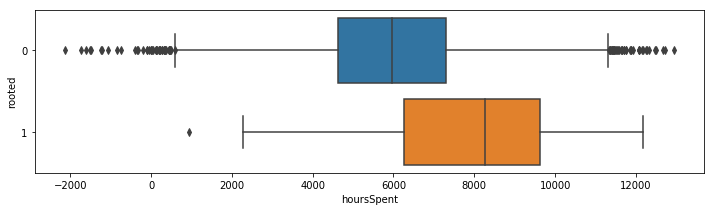

In [60]:
plt.figure(figsize=[12,3])
sns.boxplot(x='hoursSpent', y='os', data=viz.df, orient='h')
plt.show()
plt.figure(figsize=[12,3])
sns.boxplot(x='hoursSpent', y='rooted', data=viz.df, orient='h')
plt.show()

# Baseline: Linear Regression of a normally distributed dependent variable using 1 normally distributed feature

In [187]:
from sklearn import linear_model
from sklearn.model_selection import cross_val_score, cross_val_predict
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std


In [188]:
normal = createSet(targetskew=0, size=10000)
regr = linear_model.LinearRegression()

In [189]:
#sklearn
x = normal.df['screenActions']
y = normal.df['hoursSpent']
regr.fit(pd.DataFrame(x),y)
scores = cross_val_score(regr,pd.DataFrame(x),y,cv=10)
print("Fold Scores: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\nCoefficients:', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\n','-'*40)

#statsmodels

linear_formula = 'hoursSpent ~ screenActions'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=normal.df).fit()
lm.summary()

Fold Scores:  [0.49624816 0.43938776 0.50022678 0.48920265 0.51008289 0.52411655
 0.48358649 0.49096749 0.44551305 0.46167036]

Average Score:  0.484100218803308

Coefficients: [0.46159226]

Intercept: 
 451.22820398608474

 ----------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             hoursSpent   R-squared:                       0.486
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     9449.
Date:                Thu, 27 Dec 2018   Prob (F-statistic):               0.00
Time:                        10:19:26   Log-Likelihood:                -86793.
No. Observations:               10000   AIC:                         1.736e+05
Df Residuals:                    9998   BIC:                         1.736e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       451.2282     58.784      7.676      0.000     336.000     566.456
screenActions     0.4616      0.005     97.208      0.000       0.452       0.471
==============================================================================
Omnibus:                        0.177   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.915   Jarque-Bera (JB):                0.161
Skew:                           0.008   Prob(JB):                        0.923
Kurtosis:                       3.010   Cond. No.                     5.11e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.11e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

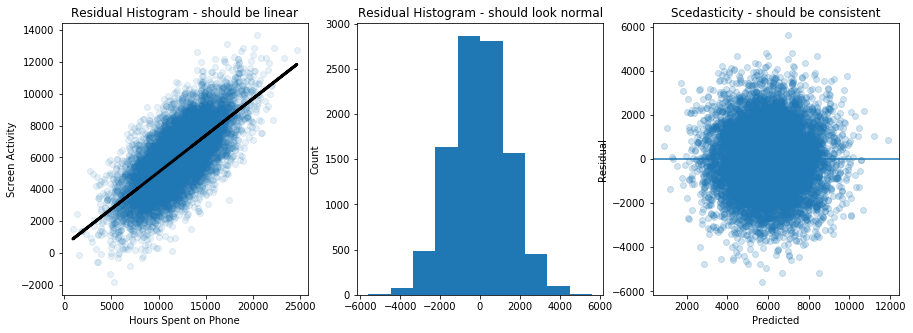

In [190]:
#Let's check how our output looks:
pred = cross_val_predict(regr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.scatter(x,y, alpha=.1)
plt.plot(x, regr.predict(pd.DataFrame(x)), color='black', linewidth=3)
plt.title('Residual Histogram - should be linear')
plt.xlabel('Hours Spent on Phone')
plt.ylabel('Screen Activity')
plt.subplot(132)
plt.hist(residual)
plt.title('Residual Histogram - should look normal')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')
plt.show()

# What if the target variable had a right skew instead of being normally distributed?

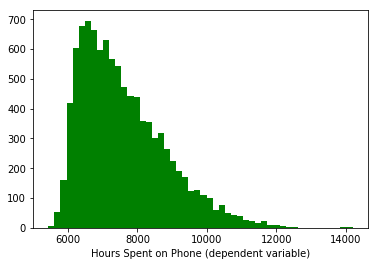

In [191]:
rightskew = createSet(targetskew=10, size=10000)
plt.hist(rightskew.df.hoursSpent, color='g', bins=50)
plt.xlabel('Hours Spent on Phone (dependent variable)')
plt.show()

regr = linear_model.LinearRegression()

In [192]:
#sklearn
x = rightskew.df['screenActions']
y = rightskew.df['hoursSpent']
regr.fit(pd.DataFrame(x),y)
scores = cross_val_score(regr,pd.DataFrame(x),y,cv=10)
print("Fold Scores: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\nCoefficients:', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\n','-'*40)
#statsmodels

linear_formula = 'hoursSpent ~ screenActions'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=rightskew.df).fit()
lm.summary()

Fold Scores:  [0.4593715  0.4498644  0.44278395 0.45832268 0.45235257 0.39981858
 0.46461747 0.48189689 0.44945743 0.46181816]

Average Score:  0.4520303634381982

Coefficients: [0.27671523]

Intercept: 
 4265.711091791878

 ----------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             hoursSpent   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.454
Method:                 Least Squares   F-statistic:                     8327.
Date:                Thu, 27 Dec 2018   Prob (F-statistic):               0.00
Time:                        10:19:51   Log-Likelihood:                -82312.
No. Observations:               10000   AIC:                         1.646e+05
Df Residuals:                    9998   BIC:                         1.646e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4265.7111     37.574    113.528      0.000    4192.058    4339.364
screenActions     0.2767      0.003     91.252      0.000       0.271       0.283
==============================================================================
Omnibus:                      731.176   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              963.107
Skew:                           0.650   Prob(JB):                    7.31e-210
Kurtosis:                       3.788   Cond. No.                     5.12e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

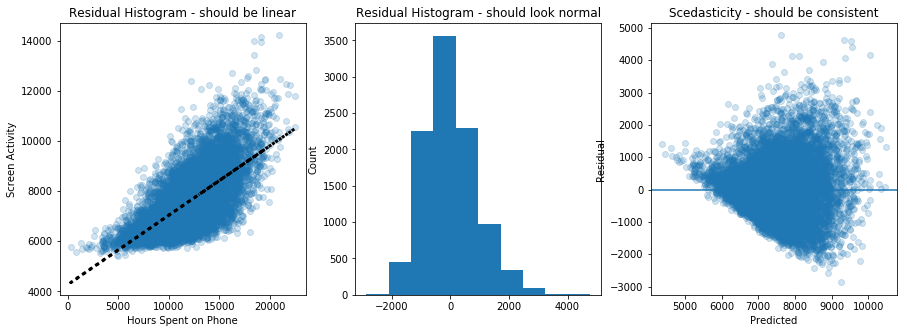

In [193]:
#Let's check how our output looks:
pred = cross_val_predict(regr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.scatter(x,y, alpha=.2)
plt.plot(x, regr.predict(pd.DataFrame(x)), color='black', lw=3, ls='dotted')
plt.title('Residual Histogram - should be linear')
plt.xlabel('Hours Spent on Phone')
plt.ylabel('Screen Activity')
plt.subplot(132)
plt.hist(residual)
plt.title('Residual Histogram - should look normal')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')
plt.show()

In [66]:
# If we use a transformation to reduce the skew, how much does it help?

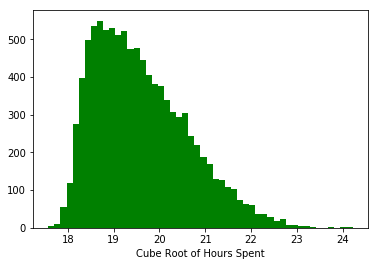

In [194]:
plt.hist(rightskew.df.hoursSpent**(1/3), color='g', bins=50)
plt.xlabel('Cube Root of Hours Spent')
plt.show()

In [195]:
rightskew.df['cube_rt_hoursSpent'] = rightskew.df['hoursSpent']**(1/3)
y = rightskew.df['cube_rt_hoursSpent']
regr.fit(pd.DataFrame(x),y)
scores = cross_val_score(regr,pd.DataFrame(x),y,cv=10)
print("Fold Scores: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\nCoefficients:', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\n','-'*40)
#statsmodels

linear_formula = 'cube_rt_hoursSpent ~ screenActions'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=rightskew.df).fit()
lm.summary()

Fold Scores:  [0.47103474 0.45883939 0.4551209  0.46953807 0.46138964 0.41289951
 0.47965425 0.49376583 0.46204899 0.4715104 ]

Average Score:  0.4635801722758541

Coefficients: [0.00023319]

Intercept: 
 16.796883333503736

 ----------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     cube_rt_hoursSpent   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.466
Method:                 Least Squares   F-statistic:                     8715.
Date:                Thu, 27 Dec 2018   Prob (F-statistic):               0.00
Time:                        10:20:05   Log-Likelihood:                -11295.
No. Observations:               10000   AIC:                         2.259e+04
Df Residuals:                    9998   BIC:                         2.261e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        16.7969      0.031    542.677      0.000      16.736      16.858
screenActions     0.0002    2.5e-06     93.353      0.000       0.000       0.000
==============================================================================
Omnibus:                      312.910   Durbin-Watson:                   2.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              342.495
Skew:                           0.443   Prob(JB):                     4.25e-75
Kurtosis:                       3.191   Cond. No.                     5.12e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.12e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

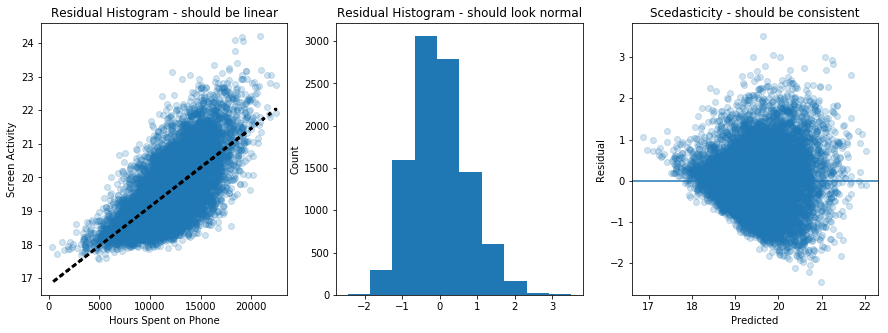

In [196]:
#Let's check how our output looks:
pred = cross_val_predict(regr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.scatter(x,y, alpha=.2)
plt.plot(x, regr.predict(pd.DataFrame(x)), color='black', lw=3, ls='dotted')
plt.title('Residual Histogram - should be linear')
plt.xlabel('Hours Spent on Phone')
plt.ylabel('Screen Activity')
plt.subplot(132)
plt.hist(residual)
plt.title('Residual Histogram - should look normal')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.2)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')
plt.show()

# How do other types of regressors do?

In [197]:
from sklearn import neighbors
from sklearn import ensemble
#from sklearn.svm import SVR


In [198]:
print("NORMAL:\n")
x = normal.df['screenActions']
y = normal.df['hoursSpent']
knn = neighbors.KNeighborsRegressor(n_neighbors=30)
knn.fit(pd.DataFrame(x),y)
scores = cross_val_score(knn,pd.DataFrame(x),y,cv=10)
print("KNN: ",scores)
print("\nAverage Score with 30 neighbors: ",np.mean(scores))
print('\n','-'*40)

rfr = ensemble.RandomForestRegressor(n_estimators=10, max_depth=3)
rfr.fit(pd.DataFrame(x),y)
scores = cross_val_score(rfr,pd.DataFrame(x),y,cv=10)
print("Random Forest Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

gbr = ensemble.GradientBoostingRegressor(loss='ls', learning_rate=.1, max_depth=2, n_estimators=100)
gbr.fit(pd.DataFrame(x),y)
scores = cross_val_score(gbr,pd.DataFrame(x),y,cv=10)
print("Gradient-Boosted Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)


#TOO SLOW:
# svm = SVR(kernel='linear')
# svm.fit(pd.DataFrame(x),y)
# scores = cross_val_score(svm,pd.DataFrame(x),y,cv=5)
# print("SVM Regressor: ",scores)
# print("\nAverage Score: ",np.mean(scores))
# print('\n','-'*40)


NORMAL:

KNN:  [0.48468281 0.42333445 0.48341933 0.48108192 0.49687338 0.5090929
 0.4671725  0.47874577 0.42348648 0.45514491]

Average Score with 30 neighbors:  0.47030344388851797

 ----------------------------------------
Random Forest Regressor:  [0.48412582 0.43184794 0.49112009 0.47473748 0.49683433 0.52356111
 0.47036452 0.482601   0.43889146 0.4546555 ]

Average Score:  0.4748739243893292

 ----------------------------------------
Gradient-Boosted Regressor:  [0.49205034 0.43526027 0.49774028 0.48346127 0.50045717 0.51707376
 0.47778296 0.48696564 0.44325605 0.4620233 ]

Average Score:  0.47960710356731706

 ----------------------------------------


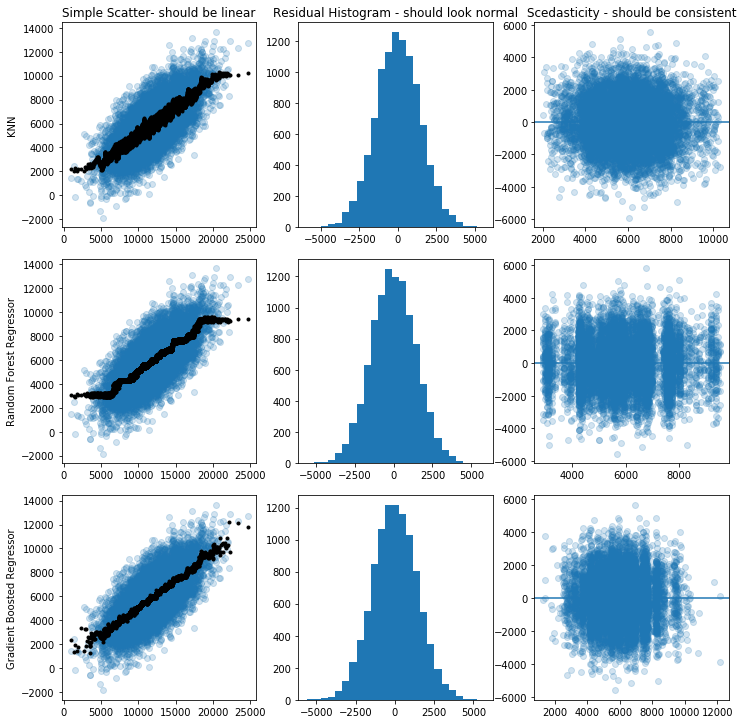

In [199]:
#Let's check how our output looks:
pred = cross_val_predict(knn,pd.DataFrame(x),y,cv=10)
residual = y - pred

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.tight_layout()
plt.subplot(331)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.title('Simple Scatter- should be linear')
plt.ylabel('KNN')
plt.subplot(332)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.subplot(333)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')

pred = cross_val_predict(rfr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(334)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Random Forest Regressor')
plt.subplot(335)
plt.hist(residual, bins=25)
plt.subplot(336)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

pred = cross_val_predict(gbr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(337)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Gradient Boosted Regressor')
plt.subplot(338)
plt.hist(residual, bins=25)
plt.subplot(339)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

plt.show()

In [200]:
# Skewed Target Variable:

print("SKEWED TARGET VARIABLE:\n")
x = rightskew.df['screenActions']
y = rightskew.df['hoursSpent']
knn = neighbors.KNeighborsRegressor(n_neighbors=30)
knn.fit(pd.DataFrame(x),y)
scores = cross_val_score(knn,pd.DataFrame(x),y,cv=10)
print("KNN: ",scores)
print("\nAverage Score with 30 neighbors: ",np.mean(scores))
print('\n','-'*40)

rfr = ensemble.RandomForestRegressor(n_estimators=10, max_depth=3)
rfr.fit(pd.DataFrame(x),y)
scores = cross_val_score(rfr,pd.DataFrame(x),y,cv=10)
print("Random Forest Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

gbr = ensemble.GradientBoostingRegressor(loss='ls', learning_rate=.1, max_depth=2, n_estimators=100)
gbr.fit(pd.DataFrame(x),y)
scores = cross_val_score(gbr,pd.DataFrame(x),y,cv=10)
print("Gradient-Boosted Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

SKEWED TARGET VARIABLE:

KNN:  [0.45195852 0.44639884 0.42726839 0.45660385 0.45767099 0.40375175
 0.47671548 0.47574499 0.44495103 0.46062662]

Average Score with 30 neighbors:  0.4501690460561341

 ----------------------------------------
Random Forest Regressor:  [0.46295225 0.46152947 0.43471283 0.46828705 0.47021003 0.39941552
 0.47900934 0.48509895 0.4540816  0.46660173]

Average Score:  0.45818987800351146

 ----------------------------------------
Gradient-Boosted Regressor:  [0.46420118 0.46725878 0.43626797 0.47487265 0.47583206 0.41568955
 0.48421399 0.49279547 0.45121022 0.47857981]

Average Score:  0.4640921666987306

 ----------------------------------------


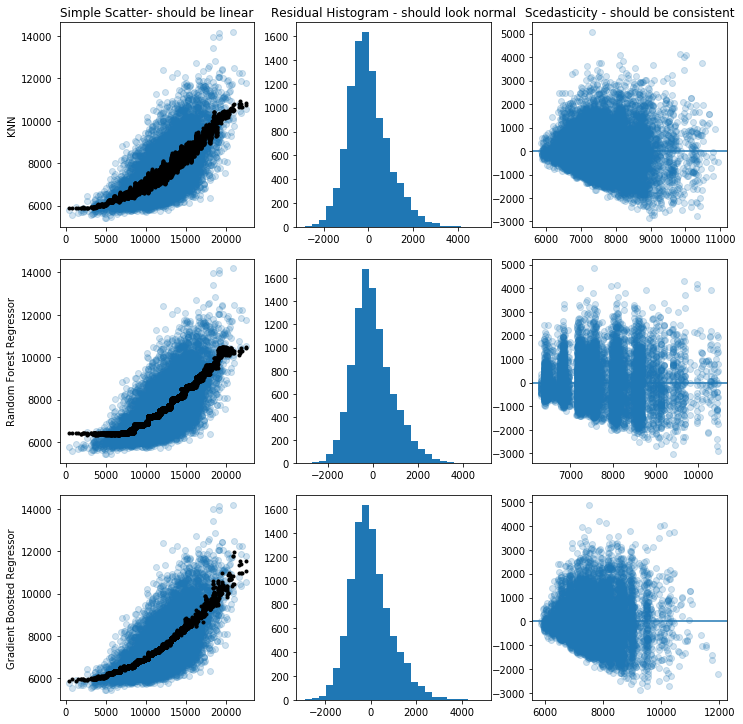

In [201]:
#Let's check how our output looks:
pred = cross_val_predict(knn,pd.DataFrame(x),y,cv=10)
residual = y - pred

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.tight_layout()
plt.subplot(331)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.title('Simple Scatter- should be linear')
plt.ylabel('KNN')
plt.subplot(332)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.subplot(333)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')

pred = cross_val_predict(rfr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(334)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Random Forest Regressor')
plt.subplot(335)
plt.hist(residual, bins=25)
plt.subplot(336)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

pred = cross_val_predict(gbr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(337)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Gradient Boosted Regressor')
plt.subplot(338)
plt.hist(residual, bins=25)
plt.subplot(339)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

plt.show()

In [202]:
# Skewed Target Variable, adjusted:

print("Adjusted :\n")
x = rightskew.df['screenActions']
y = rightskew.df['cube_rt_hoursSpent']
knn = neighbors.KNeighborsRegressor(n_neighbors=30)
knn.fit(pd.DataFrame(x),y)
scores = cross_val_score(knn,pd.DataFrame(x),y,cv=10)
print("KNN: ",scores)
print("\nAverage Score with 30 neighbors: ",np.mean(scores))
print('\n','-'*40)

rfr = ensemble.RandomForestRegressor(n_estimators=10, max_depth=3)
rfr.fit(pd.DataFrame(x),y)
scores = cross_val_score(rfr,pd.DataFrame(x),y,cv=10)
print("Random Forest Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

gbr = ensemble.GradientBoostingRegressor(loss='ls', learning_rate=.1, max_depth=2, n_estimators=100)
gbr.fit(pd.DataFrame(x),y)
scores = cross_val_score(gbr,pd.DataFrame(x),y,cv=10)
print("Gradient-Boosted Regressor: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\n','-'*40)

Adjusted :

KNN:  [0.46017064 0.44781833 0.43922139 0.4614875  0.45700727 0.41026341
 0.48213865 0.48202835 0.45485239 0.46448672]

Average Score with 30 neighbors:  0.4559474675989895

 ----------------------------------------
Random Forest Regressor:  [0.47176361 0.4619119  0.44516937 0.47588524 0.47071975 0.4092888
 0.48037816 0.4952936  0.46126194 0.4702828 ]

Average Score:  0.46419551774557843

 ----------------------------------------
Gradient-Boosted Regressor:  [0.47347882 0.46676656 0.4487028  0.48134217 0.47479588 0.42085603
 0.49140024 0.498208   0.46234756 0.48129655]

Average Score:  0.4699194607409913

 ----------------------------------------


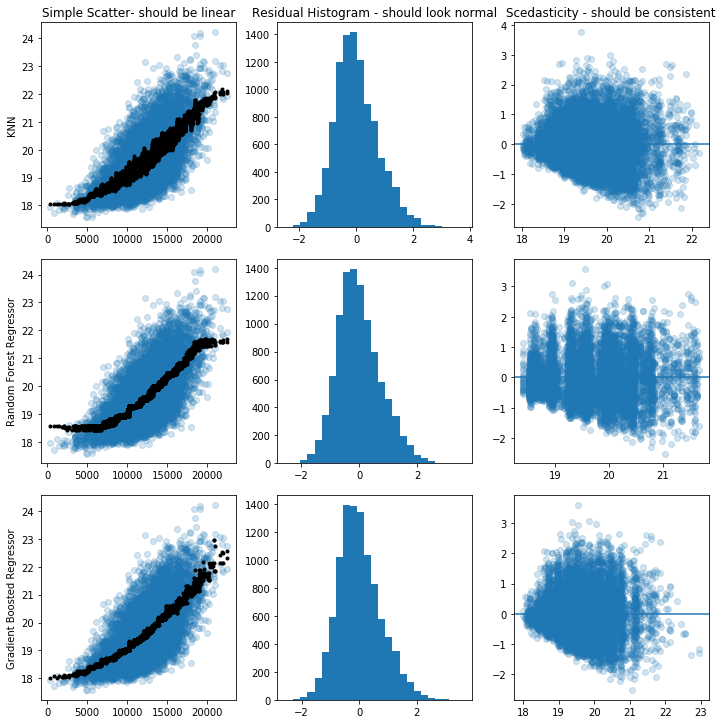

In [203]:
#Let's check how our output looks:
pred = cross_val_predict(knn,pd.DataFrame(x),y,cv=10)
residual = y - pred

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10))
fig.tight_layout()
plt.subplot(331)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.title('Simple Scatter- should be linear')
plt.ylabel('KNN')
plt.subplot(332)
plt.hist(residual, bins=25)
plt.title('Residual Histogram - should look normal')
plt.subplot(333)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')

pred = cross_val_predict(rfr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(334)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Random Forest Regressor')
plt.subplot(335)
plt.hist(residual, bins=25)
plt.subplot(336)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

pred = cross_val_predict(gbr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.subplot(337)
plt.scatter(x,y, alpha=.2)
plt.plot(x, pred, '.', color='black')
plt.ylabel('Gradient Boosted Regressor')
plt.subplot(338)
plt.hist(residual, bins=25)
plt.subplot(339)
plt.scatter(pred, residual, alpha=.2)
plt.axhline(y=0)

plt.show()

# Summary of 1-variable linear regression:
- 30% accurate when both dependent and independent variables are normally distributed
- If the Target Variable has a right skew, we lose 3% of accuracy, and additionally our model loses validity; our residuals tend to be large positives, and are much larger when the input variable is bigger.
- Cube-rooting the target variable to reduce the skew doesn't improve the R-squared score, but it does somewhat normalize residuals and scedasticity, which is useful.

KNN, Random Forest, and Gradient boosted regressors don't necessarily improve on the accuracy of simple linear regression, but they do seem to reduce the effects of a skewed target variable - in particular, Random Forest seems to extrapolate to the tail data better than any other model.


---------
# Attempting Linear Variable Regression with other data types

# 1: Normal Dependent variable,  1 Uniform feature

In [204]:
normal = createSet(targetskew=0, size=10000)
normal.df.head(2)

,hoursSpent,screenActions,picsPerMonth,timesDropped,ownerAge,rooted,os
0,6191.528616,13691,109,0,52.437849,0,iOS
1,6182.032514,12307,172,0,56.704728,0,Android


In [205]:
#sklearn
x = normal.df['picsPerMonth']
y = normal.df['hoursSpent']
regr.fit(pd.DataFrame(x),y)
scores = cross_val_score(regr,pd.DataFrame(x),y,cv=10)
print("Fold Scores: ",scores)
print("\nAverage Score: ",np.mean(scores))
print('\nCoefficients:', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\n','-'*40)

#statsmodels

linear_formula = 'hoursSpent ~ picsPerMonth'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=normal.df).fit()
lm.summary()

Fold Scores:  [0.46069955 0.42636664 0.4616824  0.502286   0.44452635 0.4710842
 0.45956247 0.47485975 0.49967929 0.45988829]

Average Score:  0.4660634943120427

Coefficients: [15.68599339]

Intercept: 
 3650.159860284788

 ----------------------------------------


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             hoursSpent   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     8791.
Date:                Thu, 27 Dec 2018   Prob (F-statistic):               0.00
Time:                        10:21:12   Log-Likelihood:                -87020.
No. Observations:               10000   AIC:                         1.740e+05
Df Residuals:                    9998   BIC:                         1.741e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     3650.1599     29.135    125.286      0.000    3593.050    3707.269
picsPerMonth    15.6860      0.167     93.758      0.000      15.358      16.014
==============================================================================
Omnibus:                        1.649   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.439   Jarque-Bera (JB):                1.661
Skew:                          -0.031   Prob(JB):                        0.436
Kurtosis:                       2.989   Cond. No.                         349.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

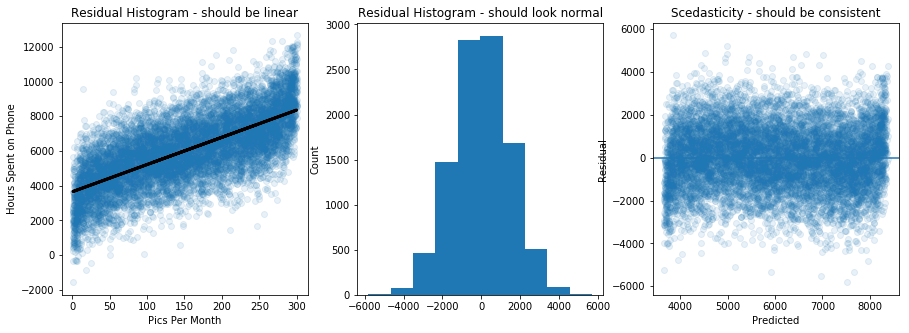

In [207]:
#Let's check how our output looks:
pred = cross_val_predict(regr,pd.DataFrame(x),y,cv=10)
residual = y - pred

plt.figure(figsize=[15,5])
plt.subplot(131)
plt.scatter(x,y, alpha=.1)
plt.plot(x, regr.predict(pd.DataFrame(x)), color='black', linewidth=3)
plt.title('Residual Histogram - should be linear')
plt.ylabel('Hours Spent on Phone')
plt.xlabel('Pics Per Month')
plt.subplot(132)
plt.hist(residual)
plt.title('Residual Histogram - should look normal')
plt.ylabel('Count')
plt.subplot(133)
plt.scatter(pred, residual, alpha=.1)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Scedasticity - should be consistent')
plt.show()

for i in range(10,50,5):
    rfr = ensemble.RandomForestRegressor(n_estimators=i, max_depth=3)
    rfr.fit(pd.DataFrame(x),y)
    scores = cross_val_score(rfr,pd.DataFrame(x),y,cv=10)
    print("\nAverage Score: ",np.mean(scores))

work  in bayesian vs frequentist thinking
p values, priors etc.

logistic regression (over/under x hours?) to discuss ROC